In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from mist_cf import common
from mist_cf.common.plot_utils import *
set_style()

In [ ]:
fig_folder = Path("../results/figures/")
fig_folder = fig_folder / "sirius_compare"
fig_folder.mkdir(parents=True, exist_ok=True)
# mdkir
fig_folder.mkdir(parents=True, exist_ok=True)
data_folder = Path("../data/nist_canopus/")
# rdbe_labels_file = data_folder / "decoy_labels/decoy_label_RDBE.tsv"
labels_file = data_folder / "labels.tsv"
labels = pd.read_csv(labels_file, sep="\t")

fold_nums = [1,2,3]
fold_to_specs = {}
for fold in fold_nums:
    split_file = data_folder / f"splits/split_{fold}.tsv"
    split_df = pd.read_csv(split_file, sep="\t")
    # Get all "spec" where "Fold_0" == "test"
    test_spec = split_df[split_df["Fold_0"] == "test"]["spec"].values
    fold_to_specs[int(fold)] = test_spec

# Get digit at end of split
get_spec_num = lambda x: int(x.split("_")[-1])

split_lens = {k: len(v) for k, v in fold_to_specs.items()}

## Benchmark load results

In [ ]:
res_folders = {
    "mist_cf_ms2": ["../results/mist_cf_predict_sirius/"],
    "sirius" : ["../results/sirius_gnps_pred/"]
}

sirius_order = [i for i in sirius_order if i in res_folders.keys()]

In [ ]:
dict_list = [{"model": model_name, "folder": f} 
             for model_name, folder_list in res_folders.items() 
             for f in folder_list]

In [ ]:
all_dfs = []
for entry in dict_list:
    folder = Path(entry["folder"])
    model = entry['model']
    # load results
    res_files = folder.rglob("full_out.tsv")
    for res_file in res_files:
        split = res_file.parent.parent.name
        df = pd.read_csv(res_file, sep="\t")
        df['split'] = split
        df['model'] = model
        all_dfs.append(df)
all_df = pd.concat(all_dfs, ignore_index=True)

In [ ]:
all_df.groupby(["model", "split",]).mean()

## Build table

In [ ]:
# Group by method, split, and compute top k accuracy through 20
def top_k_accuracy(x, top_k, denom, key_str="ind_found"):
    k_dict = []
    for k in top_k: 
        acc = np.sum(x[key_str] <= k)  / denom
        k_dict.append({"k": k, "acc": acc})
    return k_dict
split_extract = lambda x: f"split_{x.split('_')[-1]}"

top_k = [1, 2, 3, 4, 5]
#top_k_acc = all_df.groupby(["model", "split",]).apply(lambda x: top_k_accuracy(x, top_k))

keys = ["model", "split"]#, "mass_bin"]
key_strs = ["ind_found", "ind_found_adduct", "ind_found_full_form"]
out_df = []
for names, sub_df in all_df.groupby(keys):
    update_dict = dict(zip(keys, names))
    for key_str in key_strs:
        denom = split_lens[get_spec_num(names[1])]
        sub_dicts = top_k_accuracy(sub_df, top_k, key_str=key_str, denom=denom)

        out_df.extend([dict(**i, **update_dict, val=key_str) for i in sub_dicts ])
    num_submitted = int(len(sub_df))
    out_df.append(dict(k="num_submitted", val="num_submitted", acc=num_submitted,  **update_dict))
# print(out_df)
tbl_df = pd.DataFrame(out_df)


# Create latex table

# Group by split and model and take mean and std
# Reset split from index
mean_df = tbl_df.groupby(["model", "val", "k"]).mean().reset_index().round(3).sort_index()
std_df = tbl_df.groupby(["model", "val", "k"]).std().reset_index().round(3).sort_index().replace(np.nan, 0)

# display(mean_df), display(std_df)
# Loop over both dfs and create a new df using only thea ccuracy coolumn
error_df = mean_df.copy()
# str concat mean df and std df
error_df["acc"] = [rf"${mean_df['acc'][i]:.3f} \pm {std_df['acc'][i]:.3f}$" for i in range(len(mean_df))]
display(error_df)


# Filter or pivot if needed

## Build table orthogonally using already predicted results

Note this method should not be considered as the denominator is only for predicts made.

In [ ]:
# Note not to use this table!
# Build accuracy table
top_k = list(range(1,4))
tbl_df = all_df.copy()


keep_rename_map = {f"Top {k} acc.":k for k in top_k}
keep_keys = list(keep_rename_map.keys())

# Group by split and model and take mean and std
agg_df = tbl_df.groupby(["model", "split"]).mean()[keep_keys].sort_index().reset_index()

# Reset split from index
mean_df = agg_df.groupby(["model"]).mean().reset_index().round(3).sort_index()
std_df = agg_df.groupby(["model"]).std().reset_index().round(3).sort_index().replace(np.nan, 0)

error_df = mean_df.copy()
for k in keep_keys: 
    # str concat mean df and std df
    error_df[k] = [rf"${mean_df[k][i]:.3f} \pm {std_df[k][i]:.3f}$" for i in range(len(mean_df))]

# Melt so keys are "Model" "dataset" and "top k"
error_df = error_df.melt(id_vars=["model"], var_name="Top k", value_name="Accuracy")
# Pivot so it's a multi index of "Dataset", "Top k, with "Accuracy" as values 
error_df = error_df.pivot(columns=["Top k"], index="model", values="Accuracy")
error_df.index.name = "Method"

# Sort by max subpeaks
error_df = error_df.sort_index(ascending=True)

display(error_df)
latex = error_df.to_latex(caption="MIST-CF vs. SIRIUS", 
                        label="tab:sirius_compare",
                        escape=False)
print(latex)

## Analysis of which compounds were able to be formula-mapped

In [ ]:
count_df = all_df.groupby(["model", "split"]).count().reset_index()

,split,spec,max_spec,frac_predicted
0,1,2060.0,2205.0,93.424036


1 sirius 0
sirius mean: 93.42 std: 0.00


,split,spec,max_spec,frac_predicted
0,1,2205.0,2205.0,100.0


1 mist_cf_ms2 1
mist_cf_ms2 mean: 100.00 std: 0.00


/tmp/ipykernel_6063/2069365853.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(i)}%" for i in vals])


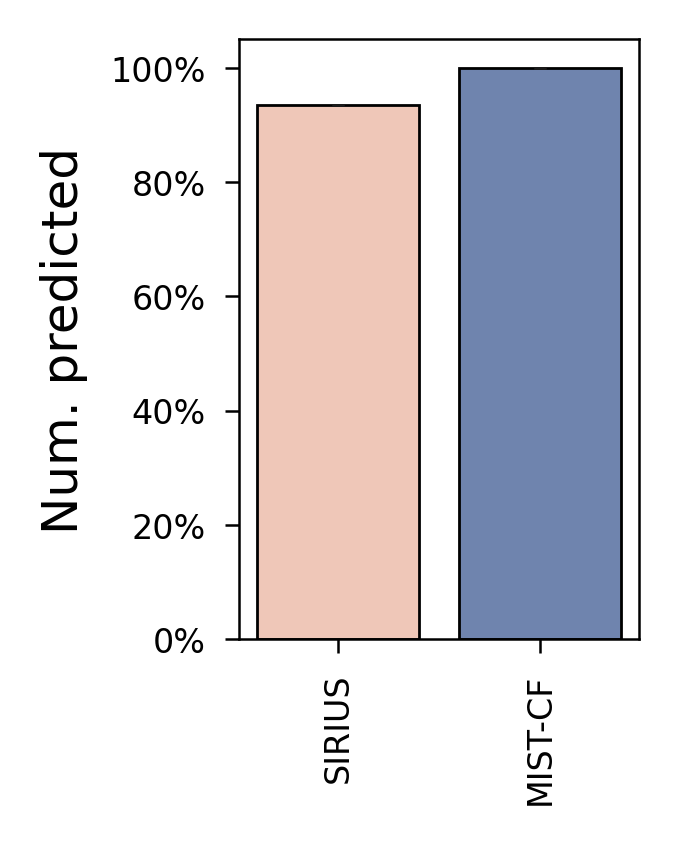

In [101]:
num_bars = len(sirius_order)
figsize = (1, 1.5)

# Build barplot
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.add_subplot(111)

considered_folds = set()
for ind, model in enumerate(sirius_order):
    model_df = count_df[count_df["model"] == model].copy()
    considered_folds.update(set(model_df["split"].apply(get_spec_num).unique()))

    # Get all splits
    splits = model_df["split"].unique()
    split_nums = [get_spec_num(i) for i in splits]
    max_specs = [len(fold_to_specs[i]) for i in split_nums]
    model_df['split']  = model_df['split'].apply(get_spec_num)
    model_df['max_spec'] = [len(fold_to_specs[i]) for i in model_df['split']]
    model_df['frac_predicted'] = model_df['spec'] / model_df['max_spec'].sum() * 100

    model_df = model_df[["split", "model", "spec", "max_spec", "frac_predicted",]].sort_values(by=["split"])

    # Groupby split and compute average 
    mean_df = model_df.groupby(["split"]).mean().reset_index()
    std_df = model_df.groupby(["split"]).std().reset_index().replace(np.nan, 0)


    display(mean_df)
    print(len(mean_df), model, ind)
    # Verify only length 1 in each of these 
    assert len(mean_df) == 1
    assert len(std_df) == 1

    mean = mean_df['frac_predicted'][0] 
    std = std_df['frac_predicted'][0]
    ci = std * 1.96 / np.sqrt(len(splits))
    print(f"{model} mean: {mean:.2f} std: {std:.2f}")
    # Plot
    ax.bar(ind, mean, yerr=std, color=color_scheme[model], label=rename_scheme[model],
    # Add black outline
    edgecolor='black', linewidth=0.5, error_kw=dict(lw=0.5, capsize=1, capthick=0.5),
    )

# Set xticks
ax.set_xticks(range(num_bars))
ax.set_xticklabels([rename_scheme[model] for model in sirius_order], rotation=90, ha="center")
ax.set_ylabel("Num. predicted")
# Switch y ticks to be percentages
vals = ax.get_yticks()
ax.set_yticklabels([f"{int(i)}%" for i in vals])

# Save to figure
set_size(*figsize, ax)
fig.savefig(fig_folder / "sirius_compare_num_predicted.pdf", bbox_inches="tight", transparent=True,)



In [103]:
# For all the spectra that could vs. couldn't be predicted by sirius 
# Build distributions of their masses

# Get all the spectra that could be predicted by sirius
all_specs = {j for k, v in fold_to_specs.items() for j in v if k in considered_folds}
predicted_specs = set(all_df[all_df["model"] == "sirius"]["spec"].values)
missed = all_specs.difference(predicted_specs)
found = all_specs.intersection(predicted_specs)
print(f"Found {len(found)} spectra")
print(f"Missed {len(missed)} spectra")
# Missed percentage
print(f"Missed {len(missed) / len(all_specs) * 100:.2f}% spectra")
print(f"Total {len(all_specs)} spectra")
assert(len(all_specs) == len(found) + len(missed))

Found 2060 spectra
Missed 145 spectra
Missed 6.58% spectra
Total 2205 spectra


In [104]:
# Map labels "spec" to "formula"
spec_to_form = dict(zip(labels["spec"], labels["formula"]))
found_form = [spec_to_form[i] for i in found]
missed_form = [spec_to_form[i] for i in missed]
from mist_cf import common
found_masses = [common.formula_mass(i) for i in found_form]
missed_masses = [common.formula_mass(i) for i in missed_form]
print(f"Found {len(found_masses)} masses")
print(f"Missed {len(missed_masses)} masses")
# Print avg of dists
print(f"Found avg: {np.mean(found_masses):.2f} std: {np.std(found_masses):.2f}")
print(f"Missed avg: {np.mean(missed_masses):.2f} std: {np.std(missed_masses):.2f}")

Found 2060 masses
Missed 145 masses
Found avg: 386.59 std: 139.38
Missed avg: 708.54 std: 159.40


/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


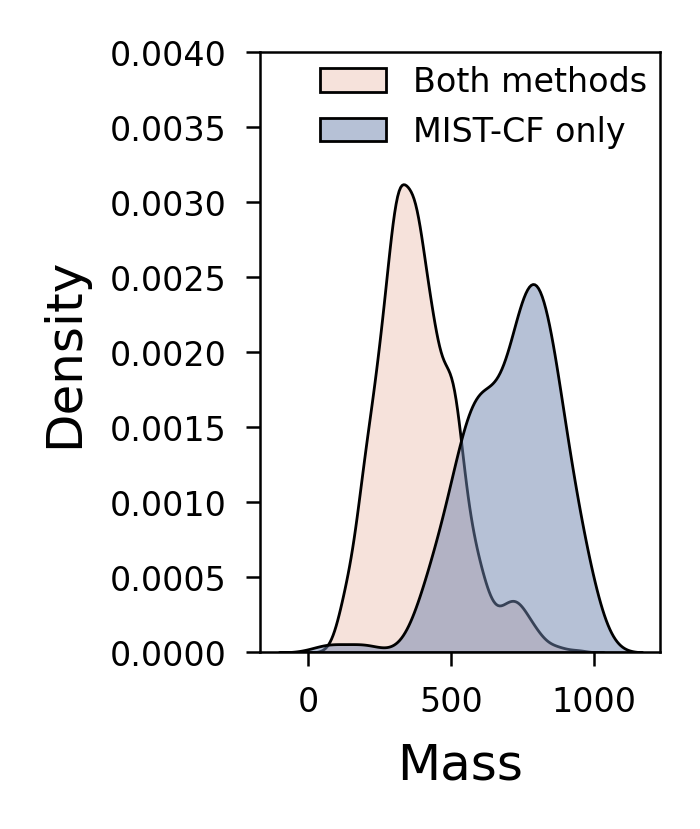

In [105]:
# Build quick distribution plot
figsize = (1, 1.5)
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.add_subplot(111)
sns.distplot(found_masses, ax=ax, label="Both methods", color="black", 
            # Only use kde
            kde=True, hist=False,
            kde_kws={"shade": True, "alpha": 0.5, "color": color_scheme["sirius"],
                    "linewidth": 0.5, "edgecolor": "black",
                      },            
)
sns.distplot(missed_masses, ax=ax, label="MIST-CF only", color=color_scheme["mist_cf_ms2"], 
            kde=True, hist=False,
            # Black border
            # Shade kde but have black border
            kde_kws = {"shade": True, "alpha": 0.5, "color": color_scheme["mist_cf_ms2"], 
                        "linewidth": 0.5, "edgecolor": "black",},)
            # kde_kws={"shade": True, "alpha": 0.5,},)
ax.set_xlabel("Mass")
ax.set_ylabel("Density")
# Make y lim higher 
ax.set_ylim(0, 0.004)
ax.legend(borderaxespad=0., frameon=False)
set_size(*figsize, ax)
# savefig
fig.savefig(fig_folder / "sirius_compare_mass_dist.pdf", bbox_inches="tight", transparent=True,)

## Line plot of acc

In [131]:
# Group by method, split, and compute top k accuracy through 20
def top_k_accuracy(x, top_k, denom, key_str="ind_found"):
    k_dict = []
    for k in top_k: 
        acc = np.sum(x[key_str] <= k)  / denom
        k_dict.append({"k": k, "acc": acc})
    return k_dict

top_k = list(range(0,21))
#top_k_acc = all_df.groupby(["model", "split",]).apply(lambda x: top_k_accuracy(x, top_k))

keys = ["model", "split"]#, "mass_bin"]
# key_strs = ["ind_found", "ind_found_adduct", "ind_found_full_form"]
key_strs = ["ind_found_full_form"]
out_df = []
for names, sub_df in all_df.groupby(keys):
    update_dict = dict(zip(keys, names))
    for key_str in key_strs:
        denom = split_lens[get_spec_num(names[1])]
        sub_dicts = top_k_accuracy(sub_df, top_k, key_str=key_str, denom=denom)

        out_df.extend([dict(**i, **update_dict, val=key_str) for i in sub_dicts ])
        
# print(out_df)
out_df = pd.DataFrame(out_df)
out_df.head()

,k,acc,model,split,val
0,0,0.000000,mist_cf_ms2,mist_cf_1,ind_found_full_form
1,1,0.800907,mist_cf_ms2,mist_cf_1,ind_found_full_form
2,2,0.873469,mist_cf_ms2,mist_cf_1,ind_found_full_form
3,3,0.896145,mist_cf_ms2,mist_cf_1,ind_found_full_form
4,4,0.903855,mist_cf_ms2,mist_cf_1,ind_found_full_form


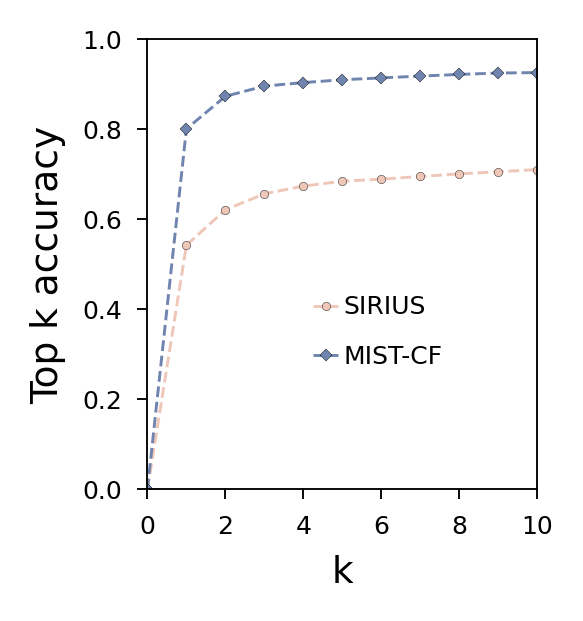

In [133]:
# Here just show the "with nist " result
# Plot out df as a line plot where each line is specific to a model, k is the x acc, and "acc" is the y axis
# Also use the splits to fill in the lines with error/deviation
# Plot the mean of the splits as a line, and the std as a shaded region

# TODO: Switch this from ind_found_full_form to having _multiple_ lines for full form and ind_found to show both..


figsize = (1.3,1.5)

# Filter outdf to only include splits with nist 
# Create two subplots
fig = plt.figure(figsize=figsize, dpi=300,)

# Add subplot
ax = fig.add_subplot(111)

# key_to_linestyle 

for method in sirius_order:
    subdf = out_df[out_df["model"] == method]

    mean_df = subdf.groupby("k").mean()
    std_df = subdf.groupby("k").std()
    # Get number of splits
    n_splits = subdf["split"].nunique()
    # Get stderror of mean and 95% conf
    std_err = std_df / np.sqrt(n_splits)
    conf = std_err * 1.96

    # Sort dfs by k 
    mean_df = mean_df.sort_index()
    conf = conf.sort_index()
    
    # Plot mean
    ax.plot(mean_df.index, mean_df["acc"], 
            label=rename_scheme[method],
            color=color_scheme[method],
            marker=marker_scheme[method], 
            # Add marker outline in black
            markeredgecolor="black",
            markeredgewidth=0.1,
            markersize=2,
            linewidth=0.7, 
            linestyle="--"
            )

    # Plot conf
    ax.fill_between(mean_df.index,
                    mean_df["acc"] - conf["acc"],
                    mean_df["acc"] + conf["acc"],
                    alpha=0.2,
                    color=color_scheme[method],)
    
ax.set_xlabel("k")
ax.set_ylabel("Top k accuracy")
ax.set_ylim(0.0,1)
uplim = 10
ax.set_xlim(0,uplim)
ax.set_xticks(np.arange(0, uplim +1, 2))
# ax.set_yscale("log")

# Make legend with no box
ax.legend(bbox_to_anchor=(0.4, 0.35), borderaxespad=0., 
        frameon=False, labelspacing=0.3, handletextpad=0.2,
        handlelength=1, loc="center left", ncol=1, )#fontsize=6)

# Remake legend but this time create slightly longer lines for all lineplots
# Create legend handles
ax.legend(bbox_to_anchor=(0.4, 0.35), borderaxespad=0.,
        frameon=False, labelspacing=0.3, handletextpad=0.2,
        handlelength=1, loc="center left", ncol=1, 

        )



# fig.tight_layout()
# Save to fig folder
set_size(*figsize, ax,)
fig.savefig(fig_folder / "lineplot_accuracy.pdf", bbox_inches="tight", transparent=True)

## Mass bins 

**Note this current implementation does not correct for differing denominators**

In [121]:
def top_k_accuracy(x, top_k):
    k_dict = []
    for k in range(top_k): 
        acc = np.mean(x['ind_found'] <= k)
        k_dict.append({"k": k, "acc": acc})
    return k_dict

top_k = 20
#top_k_acc = all_df.groupby(["model", "split",]).apply(lambda x: top_k_accuracy(x, top_k))

keys = ["model", "split", "mass_bin", ]
out_df = []
for names, sub_df in all_df.groupby(keys):
    update_dict = dict(zip(keys, names))
    sub_dicts = top_k_accuracy(sub_df, top_k)
    out_df.extend([dict(**i, **update_dict) for i in sub_dicts ])
out_df = pd.DataFrame(out_df)

In [122]:
## Subset to k = 1, split has nist
out_df_nist = out_df[(out_df["k"] == 1) ]
mass_bins = out_df_nist['mass_bin'].unique()
x_ticks = np.arange(len(mass_bins))
x_ticks_dict = dict(zip(mass_bins, x_ticks))
out_df_nist['x'] = out_df_nist['mass_bin'].map(x_ticks_dict)
out_df_nist;

/tmp/ipykernel_6063/1390395285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df_nist['x'] = out_df_nist['mass_bin'].map(x_ticks_dict)


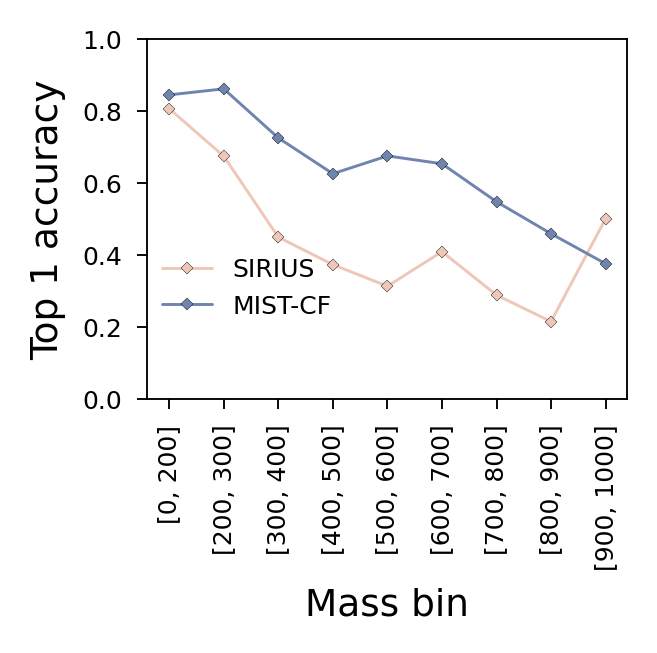

In [123]:

figsize = (1.6,1.2)
fig = plt.figure(figsize=figsize, dpi=300)
ax = fig.add_subplot(111)
for model in sirius_order:
    subdf = out_df_nist[out_df_nist["model"] == model]
    mean_df = subdf.groupby("x").mean()
    std_df = subdf.groupby("x").std()
    # Get number of splits
    n_splits = subdf["split"].nunique()
    # Get stderror of mean and 95% conf
    std_err = std_df / np.sqrt(n_splits)
    conf = std_err * 1.96

    # Sort dfs by k 
    mean_df = mean_df.sort_index()
    conf = conf.sort_index()

    
    # Plot mean
    ax.plot(mean_df.index, mean_df["acc"], 
            label=rename_scheme[model], 
            color=color_scheme[model],
            markeredgecolor="black",
            markeredgewidth=0.1,
            markersize=2,
            linewidth=0.7,
            marker=marker_scheme[method], 
            )

    # Plot conf
    ax.fill_between(mean_df.index,
                    mean_df["acc"] - conf["acc"],
                    mean_df["acc"] + conf["acc"],
                    alpha=0.2,
                    color=color_scheme[model])
    
ax.set_xlabel("Mass bin")
ax.set_ylabel("Top 1 accuracy")
ax.set_ylim(0.,1)

# Set x tick labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(mass_bins, rotation=90)


# Make legend with no box
ax.legend(bbox_to_anchor=(0.01, 0.42), loc=2, borderaxespad=0., frameon=False,
                # Less padding
                # handletextpad=0.2,
)
# fig.tight_layout()
# Save to fig folder
set_size(*figsize, ax,)
fig.savefig(fig_folder / "top_k_acc_masses.pdf", bbox_inches="tight", transparent=True)

## Head to head dot plot

In [124]:

figsize = (1.5,1.5)

# Filter outdf to only include splits with nist 
# Create two subplots
fig = plt.figure(figsize=figsize, dpi=300,)


<Figure size 450x450 with 0 Axes>

In [125]:
key = "ind_found_full_form"
max_bucket = 4

heat_df = all_df.copy()
# clip "ind_found_full_form" to max bucket
heat_df['ind_found_full_form'] = heat_df['ind_found_full_form'].clip(0, max_bucket)
heat_df['ind_found_full_form'] = heat_df['ind_found_full_form'].astype(int)

# Pivot df to be spec as index, model as columns, and ind found as values
heat_df = heat_df.pivot(index="spec", columns="model", values="ind_found_full_form")
# Fill na with max bucket
heat_df = heat_df.fillna(max_bucket)
# Convert to int
heat_df = heat_df.astype(int)
heat_df = heat_df.reset_index()
# Groupby the mist_cf_ms2 and sirius values and compute count of specs in each
heat_df = heat_df.groupby(["mist_cf_ms2", "sirius"]).count()
heat_df = heat_df.reset_index()
heat_df['spec'].sum()
heat_df.head()

model,mist_cf_ms2,sirius,spec
0,1,1,1134
1,1,2,151
2,1,3,69
3,1,4,412
4,2,1,45


In [126]:
heat_df.pivot(index="sirius", columns="mist_cf_ms2", values="spec")

mist_cf_ms2,1,2,3,4
sirius,,,,
1,1134,45,6,11
2,151,15,4,4
3,69,5,3,1
4,412,95,37,213


In [127]:
cmap = sns.color_palette("light:b", as_cmap=True)

99.99999999999999


mist_cf_ms2,1,2,3,4
sirius,,,,
4,18.684807,4.308390,1.678005,9.659864
3,3.129252,0.226757,0.136054,0.045351
2,6.848073,0.680272,0.181406,0.181406
1,51.428571,2.040816,0.272109,0.498866


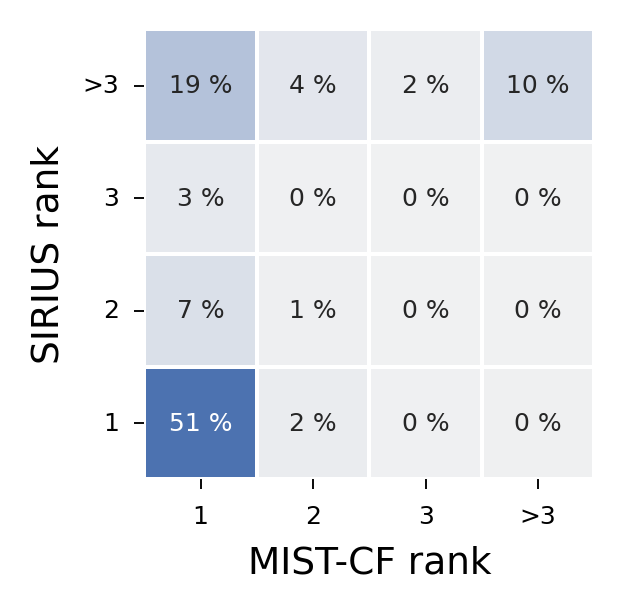

In [128]:
# Build heatmap 
figsize = (1.5,1.5)
fig = plt.figure(figsize=figsize, dpi=300,)
ax = fig.add_subplot(111)
hmap_ax = ax
# Build heatmap

plt_mat = heat_df.pivot(index="sirius", columns="mist_cf_ms2", values="spec")
plt_mat = plt_mat.fillna(0)
plt_mat = plt_mat / plt_mat.sum().sum() * 100
print(plt_mat.sum().sum())
# Put x labels above the heatmap
# Reverse sort rows
plt_mat = plt_mat.sort_index(ascending=False)
display(plt_mat)

sns.heatmap(plt_mat,
            ax=ax,
            cmap=cmap,

            # Plot numbers on top 
            annot=True,
            fmt = '.0f', square=1, 
            linewidth=0.5,
            # Set size of annot
            annot_kws={"size": 6},
            # Shrink cbar
            # set cbar to have min 0 and max 100
            vmin=0, #vmax=100,
            cbar_kws={"shrink": 0.5,}, 
            cbar = False,
)
for t in ax.texts: t.set_text(t.get_text() + " %")
# Set cbar to percentage labels
# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 25, 50, 75, 100])
# cbar.set_ticklabels([f"{i}%" for i in [0, 25, 50, 75, 100]])

ax.set_xlabel("MIST-CF rank")
ax.set_ylabel("SIRIUS rank")
# Set x ticks
# Make sure that the last bucket for 6 has string text ">max_bucket - 1"
tick_vals = np.arange(1, max_bucket + 1)
ticks =  tick_vals + 0.5
# ax.set_xticks(ticks)
# Relabel all ticks to have >5 in the last one
ticks = ax.get_xticklabels()
ticks = [int(i.get_text()) for i in ticks]
ax.set_xticklabels([f"{i}" if i != max_bucket else f">{max_bucket - 1}" for i in ticks], rotation=0)

# Switch x tick labels to be on top of plot
# ax.xaxis.tick_bottom()
# ax.xaxis.set_label_position('top')
# ax.yaxis.s

# Get current y tick text labels
ticks = ax.get_yticklabels()
ticks = [int(i.get_text()) for i in ticks]

ax.set_yticklabels([f"{i}" if i != max_bucket else f">{max_bucket - 1}" for i in ticks], rotation=0)

# Save fig
set_size(*figsize, hmap_ax,)
# Set aspect to 1
hmap_ax.set_aspect(1)
fig.savefig(fig_folder / "heatmap.pdf", bbox_inches="tight", transparent=True)
